In [1]:
# Cell 1 — Imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from matplotlib.ticker import MaxNLocator

# Plotting defaults (matplotlib). Do NOT hardcode colors so default palette is used.
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 6)


In [3]:
# Cell 2 — Load dataset
file_path = "Netflix Dataset.csv"
df = pd.read_csv(file_path)

# quick peek
print("Rows, Columns:", df.shape)
display(df.head())


Rows, Columns: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
# Cell 3 — Basic cleaning & parse Release_Date to datetime + create 'year'
# Many rows have month-day-year strings like "January 1, 2020"
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

# Create year column (int, NaN allowed)
df['year'] = df['Release_Date'].dt.year

# If Release_Date missing, try to infer year from Description or other columns (optional)
# For now we'll keep null years as NaN and drop when plotting time trends.
print("Release_Date parsed; sample years:")
display(df[['Release_Date','year']].head(10))


Release_Date parsed; sample years:


,Release_Date,year
0,2020-08-14,2020.0
1,2016-12-23,2016.0
2,2018-12-20,2018.0
3,2017-11-16,2017.0
4,2020-01-01,2020.0
5,2017-07-01,2017.0
6,2020-06-01,2020.0
7,2019-11-01,2019.0
8,2019-04-01,2019.0
9,2017-12-15,2017.0


In [7]:
# Cell 4 — Standardize Category/Type fields
# The dataset has 'Category' (TV Show vs Movie?) and also 'Category' might be named differently.
# From your earlier preview, `Category` seems to contain 'TV Show' or 'Movie' — check unique vals:
print("Unique values in Category column:", df['Category'].unique())

# Some datasets use 'Category' or 'Type' differently.
# In your earlier preview I saw both 'Category' (probably TV Show/Movie) and 'Type' (genres).
# Ensure a column 'Category_clean' with two classes: 'Movie' and 'TV Show'
def normalize_category(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if 'movie' in x:
        return 'Movie'
    if 'tv' in x or 'show' in x:
        return 'TV Show'
    # fallback: preserve original
    return x.title()

df['Category_clean'] = df['Category'].apply(normalize_category)
print(df['Category_clean'].value_counts(dropna=False).head(20))


Unique values in Category column: ['TV Show' 'Movie']
Category_clean
Movie      5379
TV Show    2410
Name: count, dtype: int64


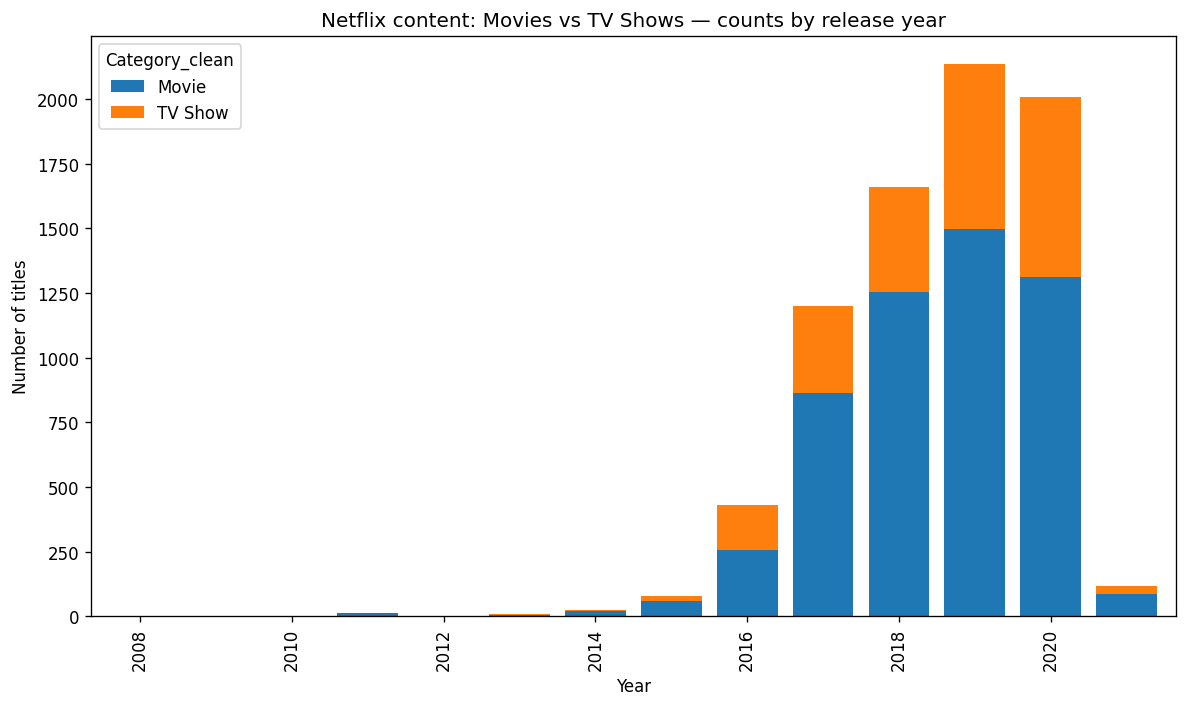

Saved aggregated counts to year_category_counts.csv


In [9]:
# Cell 5 — Objective 1: Movies vs TV Shows distribution over the years
# We'll count by year and Category_clean.

# Filter to rows with a valid year and valid Category
df_time = df.dropna(subset=['year','Category_clean']).copy()
df_time['year'] = df_time['year'].astype(int)

# Yearly counts
year_cat_counts = df_time.groupby(['year','Category_clean']).size().unstack(fill_value=0).sort_index()

# Plot stacked area or stacked bar
ax = year_cat_counts.plot(kind='bar', stacked=True, width=0.8)
ax.set_title("Netflix content: Movies vs TV Shows — counts by release year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of titles")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.tight_layout()
plt.show()

# Save to csv for reporting
year_cat_counts.to_csv('year_category_counts.csv')
print("Saved aggregated counts to year_category_counts.csv")


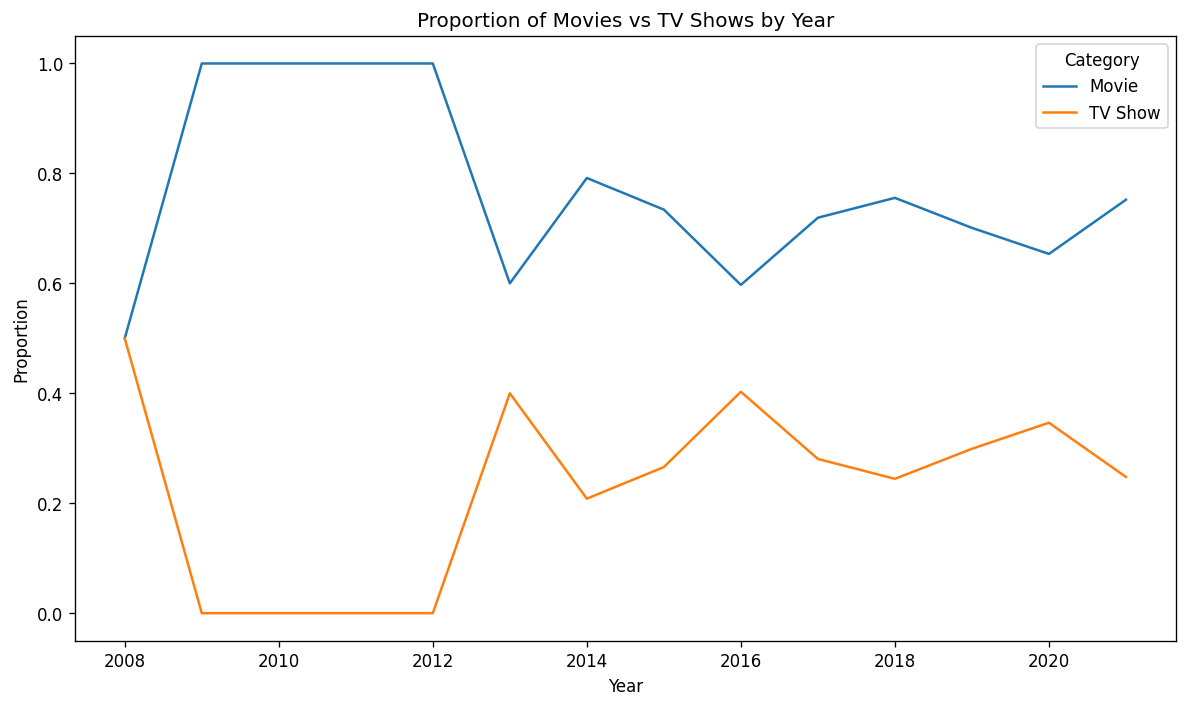

In [10]:
# Cell 6 — Also show cumulative / proportion trend
prop = year_cat_counts.div(year_cat_counts.sum(axis=1), axis=0)
ax = prop.plot()
ax.set_title("Proportion of Movies vs TV Shows by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion")
ax.legend(title='Category')
plt.tight_layout()
plt.show()


In [11]:
# Cell 7 — Preprocess 'Type' column (genres).
# Many rows contain multiple genres separated by commas, slashes, ampersands, "and", etc.
def split_genres(text):
    if pd.isna(text):
        return []
    # replace common connectors with comma, then split
    text = re.sub(r'\s*&\s*', ',', text)
    text = re.sub(r'\s*/\s*', ',', text)
    text = re.sub(r'\s+and\s+', ',', text, flags=re.IGNORECASE)
    text = re.sub(r';', ',', text)
    # split on comma, strip whitespace
    parts = [p.strip() for p in re.split(r',', text) if p.strip()]
    # Optional: normalize capitalization
    parts = [p.title() for p in parts]
    return parts

# Create exploded genres DataFrame
df['genres_list'] = df['Type'].apply(split_genres)

# Quick check
display(df[['Type','genres_list']].head(10))


,Type,genres_list
0,"International TV Shows, TV Dramas, TV Sci-Fi &...","[International Tv Shows, Tv Dramas, Tv Sci-Fi,..."
1,"Dramas, International Movies","[Dramas, International Movies]"
2,"Horror Movies, International Movies","[Horror Movies, International Movies]"
3,"Action & Adventure, Independent Movies, Sci-Fi...","[Action, Adventure, Independent Movies, Sci-Fi..."
4,Dramas,[Dramas]
5,"International TV Shows, TV Dramas, TV Mysteries","[International Tv Shows, Tv Dramas, Tv Mysteries]"
6,"Horror Movies, International Movies","[Horror Movies, International Movies]"
7,Dramas,[Dramas]
8,"Horror Movies, International Movies","[Horror Movies, International Movies]"
9,"Horror Movies, International Movies, Thrillers","[Horror Movies, International Movies, Thrillers]"


In [12]:
# Cell 8 — Identify top N genres overall
all_genres = Counter()
df['genres_list'].apply(all_genres.update)
top_n = 15
top_genres = [g for g,_ in all_genres.most_common(top_n)]
print("Top genres overall (top {}):".format(top_n))
for i,(g,cnt) in enumerate(all_genres.most_common(top_n),1):
    print(f"{i}. {g}: {cnt}")


Top genres overall (top 15):
1. International Movies: 2437
2. Dramas: 2108
3. Comedies: 1472
4. International Tv Shows: 1199
5. Adventure: 871
6. Documentaries: 786
7. Action: 721
8. Tv Dramas: 704
9. Independent Movies: 675
10. Children: 532
11. Family Movies: 532
12. Romantic Movies: 531
13. Tv Comedies: 525
14. Thrillers: 492
15. Crime Tv Shows: 427


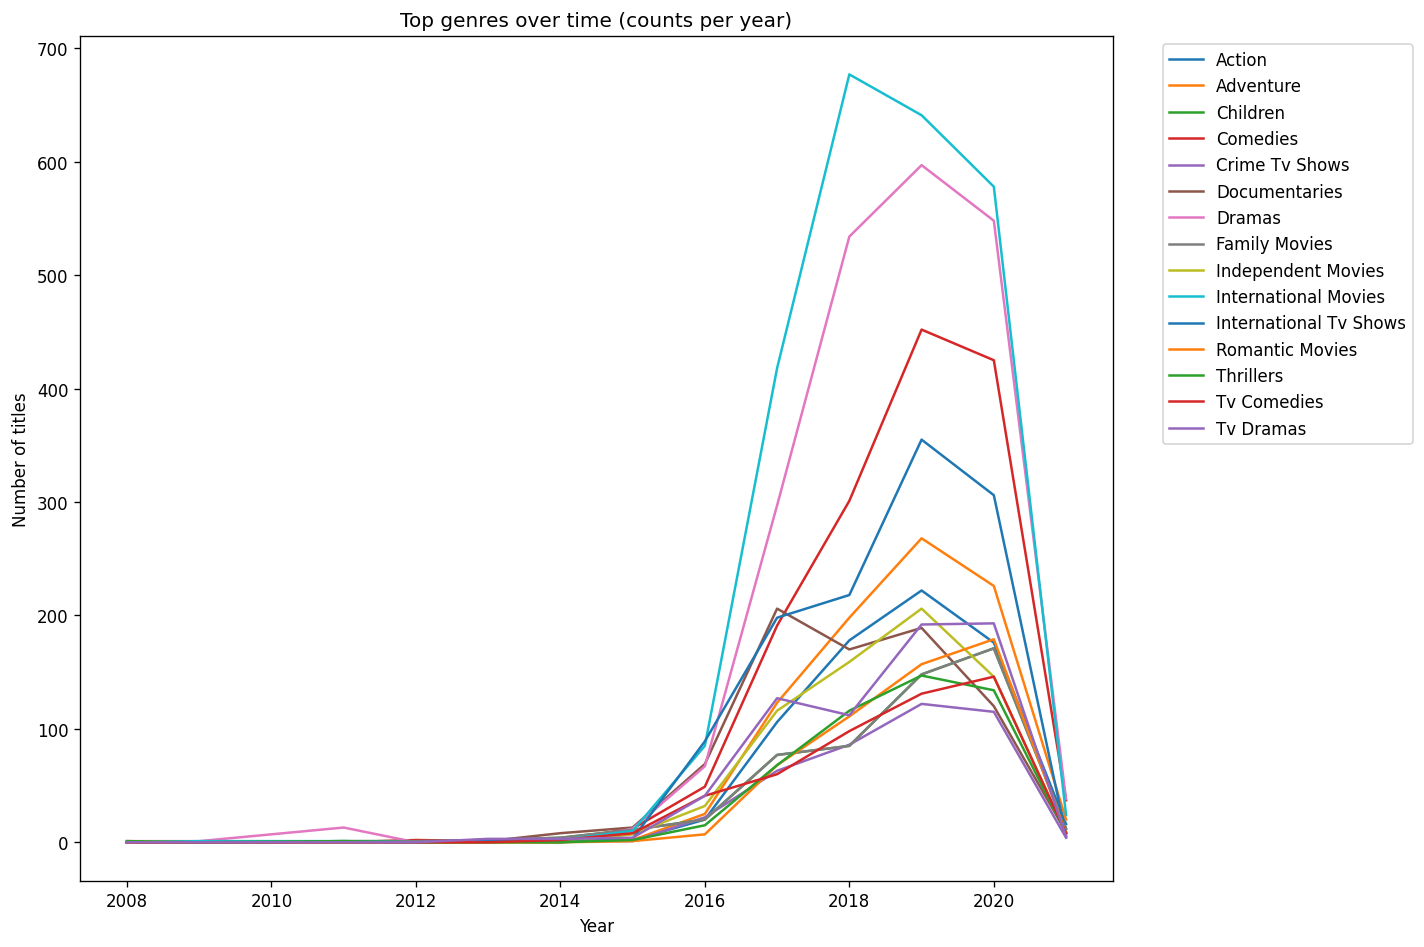

Saved genre-year counts to genre_year_counts_top15.csv


In [14]:
# Cell 9 — Create year vs genre time series for the top genres
# We'll explode the dataset so each (title, year, genre) is one row
df_genre_exploded = df.explode('genres_list').rename(columns={'genres_list':'genre'})
# drop empty genre rows and missing year
df_genre_clean = df_genre_exploded.dropna(subset=['genre','year']).copy()
df_genre_clean['year'] = df_genre_clean['year'].astype(int)

# Filter to top genres only to keep plots readable
df_top_gen = df_genre_clean[df_genre_clean['genre'].isin(top_genres)].copy()

# Year by genre counts pivot
genre_year_counts = df_top_gen.groupby(['year','genre']).size().unstack(fill_value=0).sort_index()

# Plot time series for each top genre (line chart)
ax = genre_year_counts.plot.line(subplots=False, legend=True, figsize=(12,8))
ax.set_title("Top genres over time (counts per year)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of titles")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.show()

# Save CSV
genre_year_counts.to_csv('genre_year_counts_top15.csv')
print("Saved genre-year counts to genre_year_counts_top15.csv")


In [16]:
# Cell 10 — Show change metrics for genres: growth rates, 1st half vs 2nd half comparisons
# Compute total counts per decade or per time period. Here using first/last 5 years as example.
years_sorted = sorted(df_genre_clean['year'].unique())
if len(years_sorted) >= 10:
    # define early period = first 5 full years, late period = last 5 full years
    early_years = years_sorted[:5]
    late_years = years_sorted[-5:]
else:
    # fallback: split by median year
    median = int(np.median(years_sorted))
    early_years = [y for y in years_sorted if y <= median]
    late_years = [y for y in years_sorted if y > median]

summary = []
for g in top_genres:
    early_count = df_genre_clean[df_genre_clean['genre'].eq(g) & df_genre_clean['year'].isin(early_years)].shape[0]
    late_count  = df_genre_clean[df_genre_clean['genre'].eq(g) & df_genre_clean['year'].isin(late_years)].shape[0]
    growth = (late_count - early_count) / (early_count if early_count>0 else 1)
    summary.append({'genre':g, 'early_count':early_count, 'late_count':late_count, 'growth':growth})

summary_df = pd.DataFrame(summary).sort_values('growth', ascending=False)
display(summary_df)
summary_df.to_csv('genre_growth_summary_top15.csv', index=False)
print("Saved genre growth summary to genre_growth_summary_top15.csv")


,genre,early_count,late_count,growth
0,International Movies,2,2338,1168.000000
3,International Tv Shows,0,1083,1083.000000
4,Adventure,0,835,835.000000
2,Comedies,2,1406,702.000000
6,Action,0,698,698.000000
5,Documentaries,1,694,693.000000
8,Independent Movies,1,635,634.000000
7,Tv Dramas,0,629,629.000000
11,Romantic Movies,0,523,523.000000
12,Tv Comedies,0,443,443.000000


Saved genre growth summary to genre_growth_summary_top15.csv


In [18]:
# Cell 11 — Objective 3: Country-wise contributions
# The 'Country' column can have multiple countries/regions per title.
def split_countries(text):
    if pd.isna(text):
        return []
    # Split on comma, slash, ampersand, semicolon
    text = re.sub(r'\s*&\s*', ',', text)
    text = re.sub(r'\s*/\s*', ',', text)
    parts = [p.strip() for p in re.split(r',|;', text) if p.strip()]
    return parts

df['countries_list'] = df['Country'].apply(split_countries)
df_country_exploded = df.explode('countries_list').rename(columns={'countries_list':'country'})
df_country_exploded['country'] = df_country_exploded['country'].str.title().str.strip()

# Top contributing countries overall
country_counts = df_country_exploded['country'].value_counts().head(20)
print("Top 20 countries by number of titles:")
display(country_counts)

# Save
country_counts.to_csv('top_countries_overall.csv')


Top 20 countries by number of titles:


,count
country,
United States,3298
India,990
United Kingdom,723
Canada,412
France,349
Japan,287
Spain,215
South Korea,212
Germany,199


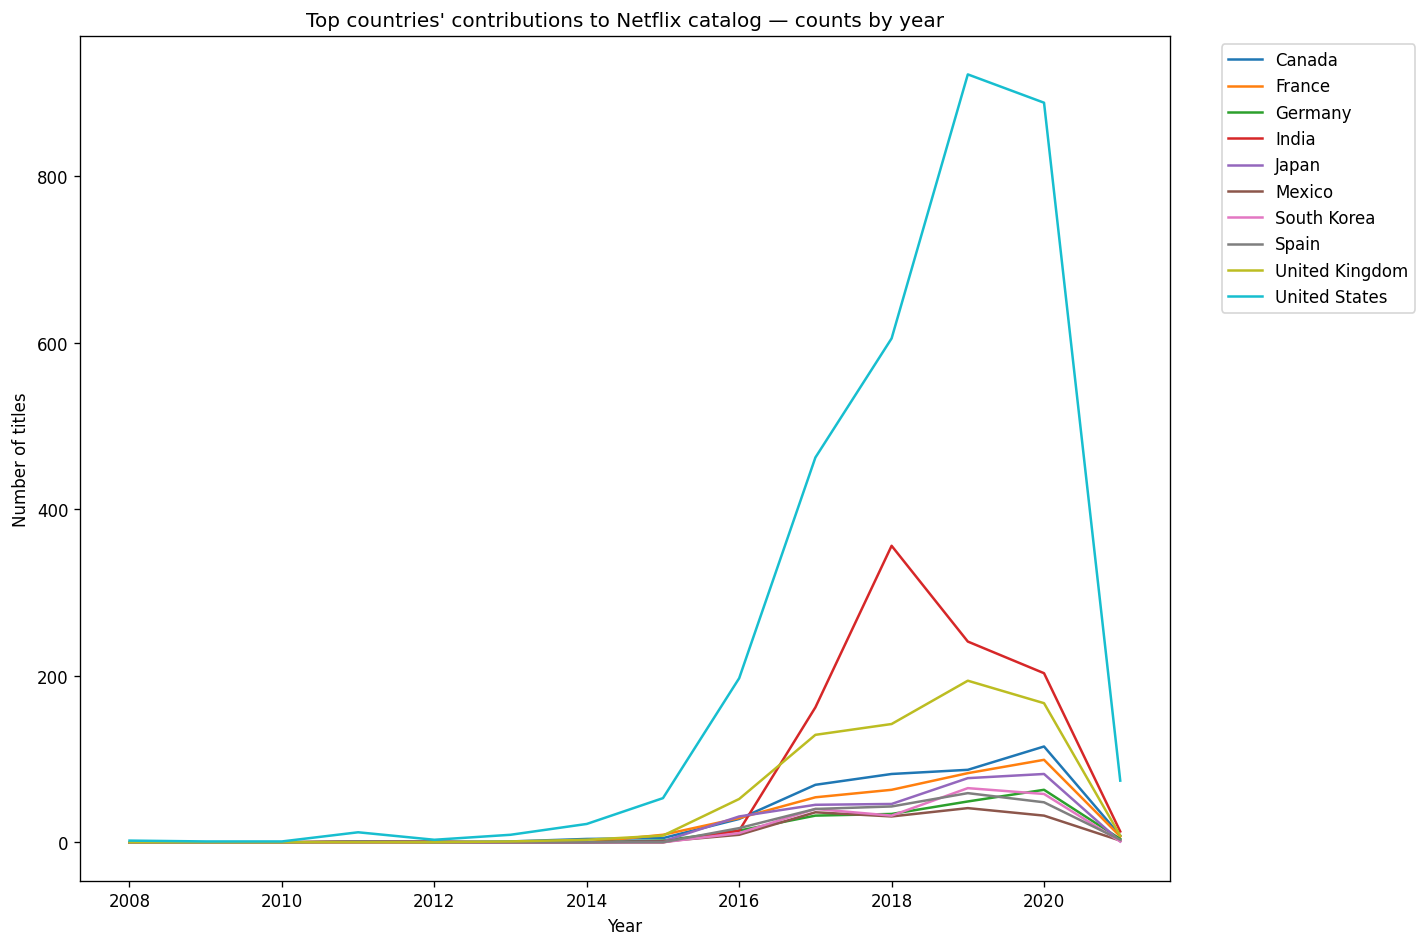

Saved country-year counts (top10) to country_year_counts_top10.csv


In [20]:
# Cell 12 — Country trends over time for top countries
top_countries = country_counts.index.tolist()[:10]  # top 10 for clarity
df_country_time = df_country_exploded.dropna(subset=['year']).copy()
df_country_time['year'] = df_country_time['year'].astype(int)
country_year_counts = df_country_time[df_country_time['country'].isin(top_countries)].groupby(['year','country']).size().unstack(fill_value=0).sort_index()

# Plot stacked area or lines for these top countries
ax = country_year_counts.plot.line(figsize=(12,8))
ax.set_title("Top countries' contributions to Netflix catalog — counts by year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of titles")
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.show()

# Save
country_year_counts.to_csv('country_year_counts_top10.csv')
print("Saved country-year counts (top10) to country_year_counts_top10.csv")


In [22]:
# Cell 13 — Additional useful analyses & outputs
# a) Top directors (who contribute the most)
top_directors = df['Director'].dropna().str.split(',', expand=True).stack().str.strip().value_counts().head(20)
print("Top 20 directors (by number of titles listed):")
display(top_directors)
top_directors.to_csv('top_directors.csv')

# b) Distribution of ratings
rating_counts = df['Rating'].fillna('Unknown').value_counts()
print("Rating distribution:")
display(rating_counts)
rating_counts.to_csv('rating_counts.csv')

# c) Duration parsing example: extract minutes or seasons
def parse_duration(s):
    if pd.isna(s):
        return np.nan
    m = re.search(r'(\d+)\s*min', s, flags=re.IGNORECASE)
    if m:
        return int(m.group(1))
    m2 = re.search(r'(\d+)\s*Season', s, flags=re.IGNORECASE)
    if m2:
        return int(m2.group(1))
    # fallback: try to get any number
    m3 = re.search(r'(\d+)', s)
    return int(m3.group(1)) if m3 else np.nan

df['duration_parsed'] = df['Duration'].apply(parse_duration)
display(df[['Duration','duration_parsed']].head(10))
df['duration_parsed'].describe().to_frame().to_csv('duration_stats.csv')


Top 20 directors (by number of titles listed):


,count
Jan Suter,21
Raúl Campos,19
Marcus Raboy,16
Jay Karas,15
Cathy Garcia-Molina,13
Jay Chapman,12
Youssef Chahine,12
Martin Scorsese,12
Steven Spielberg,10
Shannon Hartman,9


Rating distribution:


,count
Rating,
TV-MA,2865
TV-14,1931
TV-PG,806
R,665
PG-13,386
TV-Y,280
TV-Y7,271
PG,247
TV-G,194


,Duration,duration_parsed
0,4 Seasons,4
1,93 min,93
2,78 min,78
3,80 min,80
4,123 min,123
5,1 Season,1
6,95 min,95
7,119 min,119
8,118 min,118
9,143 min,143


In [23]:
# Cell 14 — Quick strategic recommendation generator (skeletal)
# Use simple heuristics to give suggestions based on output above.
# This is a starting point for writing the recommendations section of your report.
recommendations = []

# Example heuristics (customize after inspecting results)
# - If proportion of TV Shows rising, suggest more investment in serialized content.
# - If a genre shows strong growth over recent 5 years, recommend more localized originals in that genre.
# - If specific countries are increasing, suggest regional content hubs.

# Check proportion trend for TV Shows
if 'TV Show' in year_cat_counts.columns and 'Movie' in year_cat_counts.columns:
    recent_years = year_cat_counts.index[-5:] if len(year_cat_counts) >= 5 else year_cat_counts.index
    tv_share_recent = year_cat_counts.loc[recent_years,'TV Show'].sum() / year_cat_counts.loc[recent_years].sum().sum()
    tv_share_earlier = year_cat_counts.loc[year_cat_counts.index[:5],'TV Show'].sum() / year_cat_counts.loc[year_cat_counts.index[:5]].sum().sum() if len(year_cat_counts) >= 10 else 0
    if tv_share_recent > tv_share_earlier:
        recommendations.append("Invest more in TV Shows and serialized content; share of TV shows has grown recently.")
    else:
        recommendations.append("Movies remain strategically important; continue balancing movie investments.")

# Top growing genres from summary_df
top_growing = summary_df.sort_values('growth', ascending=False).head(5)
recommendations.append("Top growing genres (recently): " + ", ".join(top_growing['genre'].tolist()))

# Top countries to consider
top_country_list = country_counts.head(5).index.tolist()
recommendations.append("Top contributing countries: " + ", ".join(top_country_list))

# Print suggestions
print("\nAutomatic recommendations (draft):")
for r in recommendations:
    print("-", r)

# Save recommendations to file
with open('recommendations_draft.txt','w') as f:
    f.write("\n".join(recommendations))
print("Saved draft recommendations to recommendations_draft.txt")



Automatic recommendations (draft):
- Invest more in TV Shows and serialized content; share of TV shows has grown recently.
- Top growing genres (recently): International Movies, International Tv Shows, Adventure, Comedies, Action
- Top contributing countries: United States, India, United Kingdom, Canada, France
Saved draft recommendations to recommendations_draft.txt
